In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import cv2

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

from predefined_functions import *

In [4]:
# Walk through each directory
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
dataset = "animals"
walk_through_dir(dataset)

There are 106 directories and 0 images in 'animals'.
There are 0 directories and 90 images in 'animals\aardvark'.
There are 0 directories and 90 images in 'animals\albatross'.
There are 0 directories and 90 images in 'animals\alligator'.
There are 0 directories and 94 images in 'animals\alpaca'.
There are 0 directories and 90 images in 'animals\ant'.
There are 0 directories and 91 images in 'animals\anteater'.
There are 0 directories and 92 images in 'animals\antelope'.
There are 0 directories and 87 images in 'animals\ape'.
There are 0 directories and 89 images in 'animals\armadillo'.
There are 0 directories and 87 images in 'animals\baboon'.
There are 0 directories and 92 images in 'animals\badger'.
There are 0 directories and 90 images in 'animals\bat'.
There are 0 directories and 92 images in 'animals\bear'.
There are 0 directories and 90 images in 'animals\bee'.
There are 0 directories and 93 images in 'animals\beetle'.
There are 0 directories and 113 images in 'animals\bird'.
The

In [5]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [6]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

Label
bird           225
cattle         220
caterpillar    220
elk            217
echinda        200
              ... 
cat            110
cow             90
dog             90
horse           88
squirrel        87
Name: count, Length: 106, dtype: int64


C:\Users\farha\AppData\Local\Temp\ipykernel_15368\3644734815.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
C:\Users\farha\AppData\Local\Temp\ipykernel_15368\3644734815.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(label_counts.index, rotation=45)


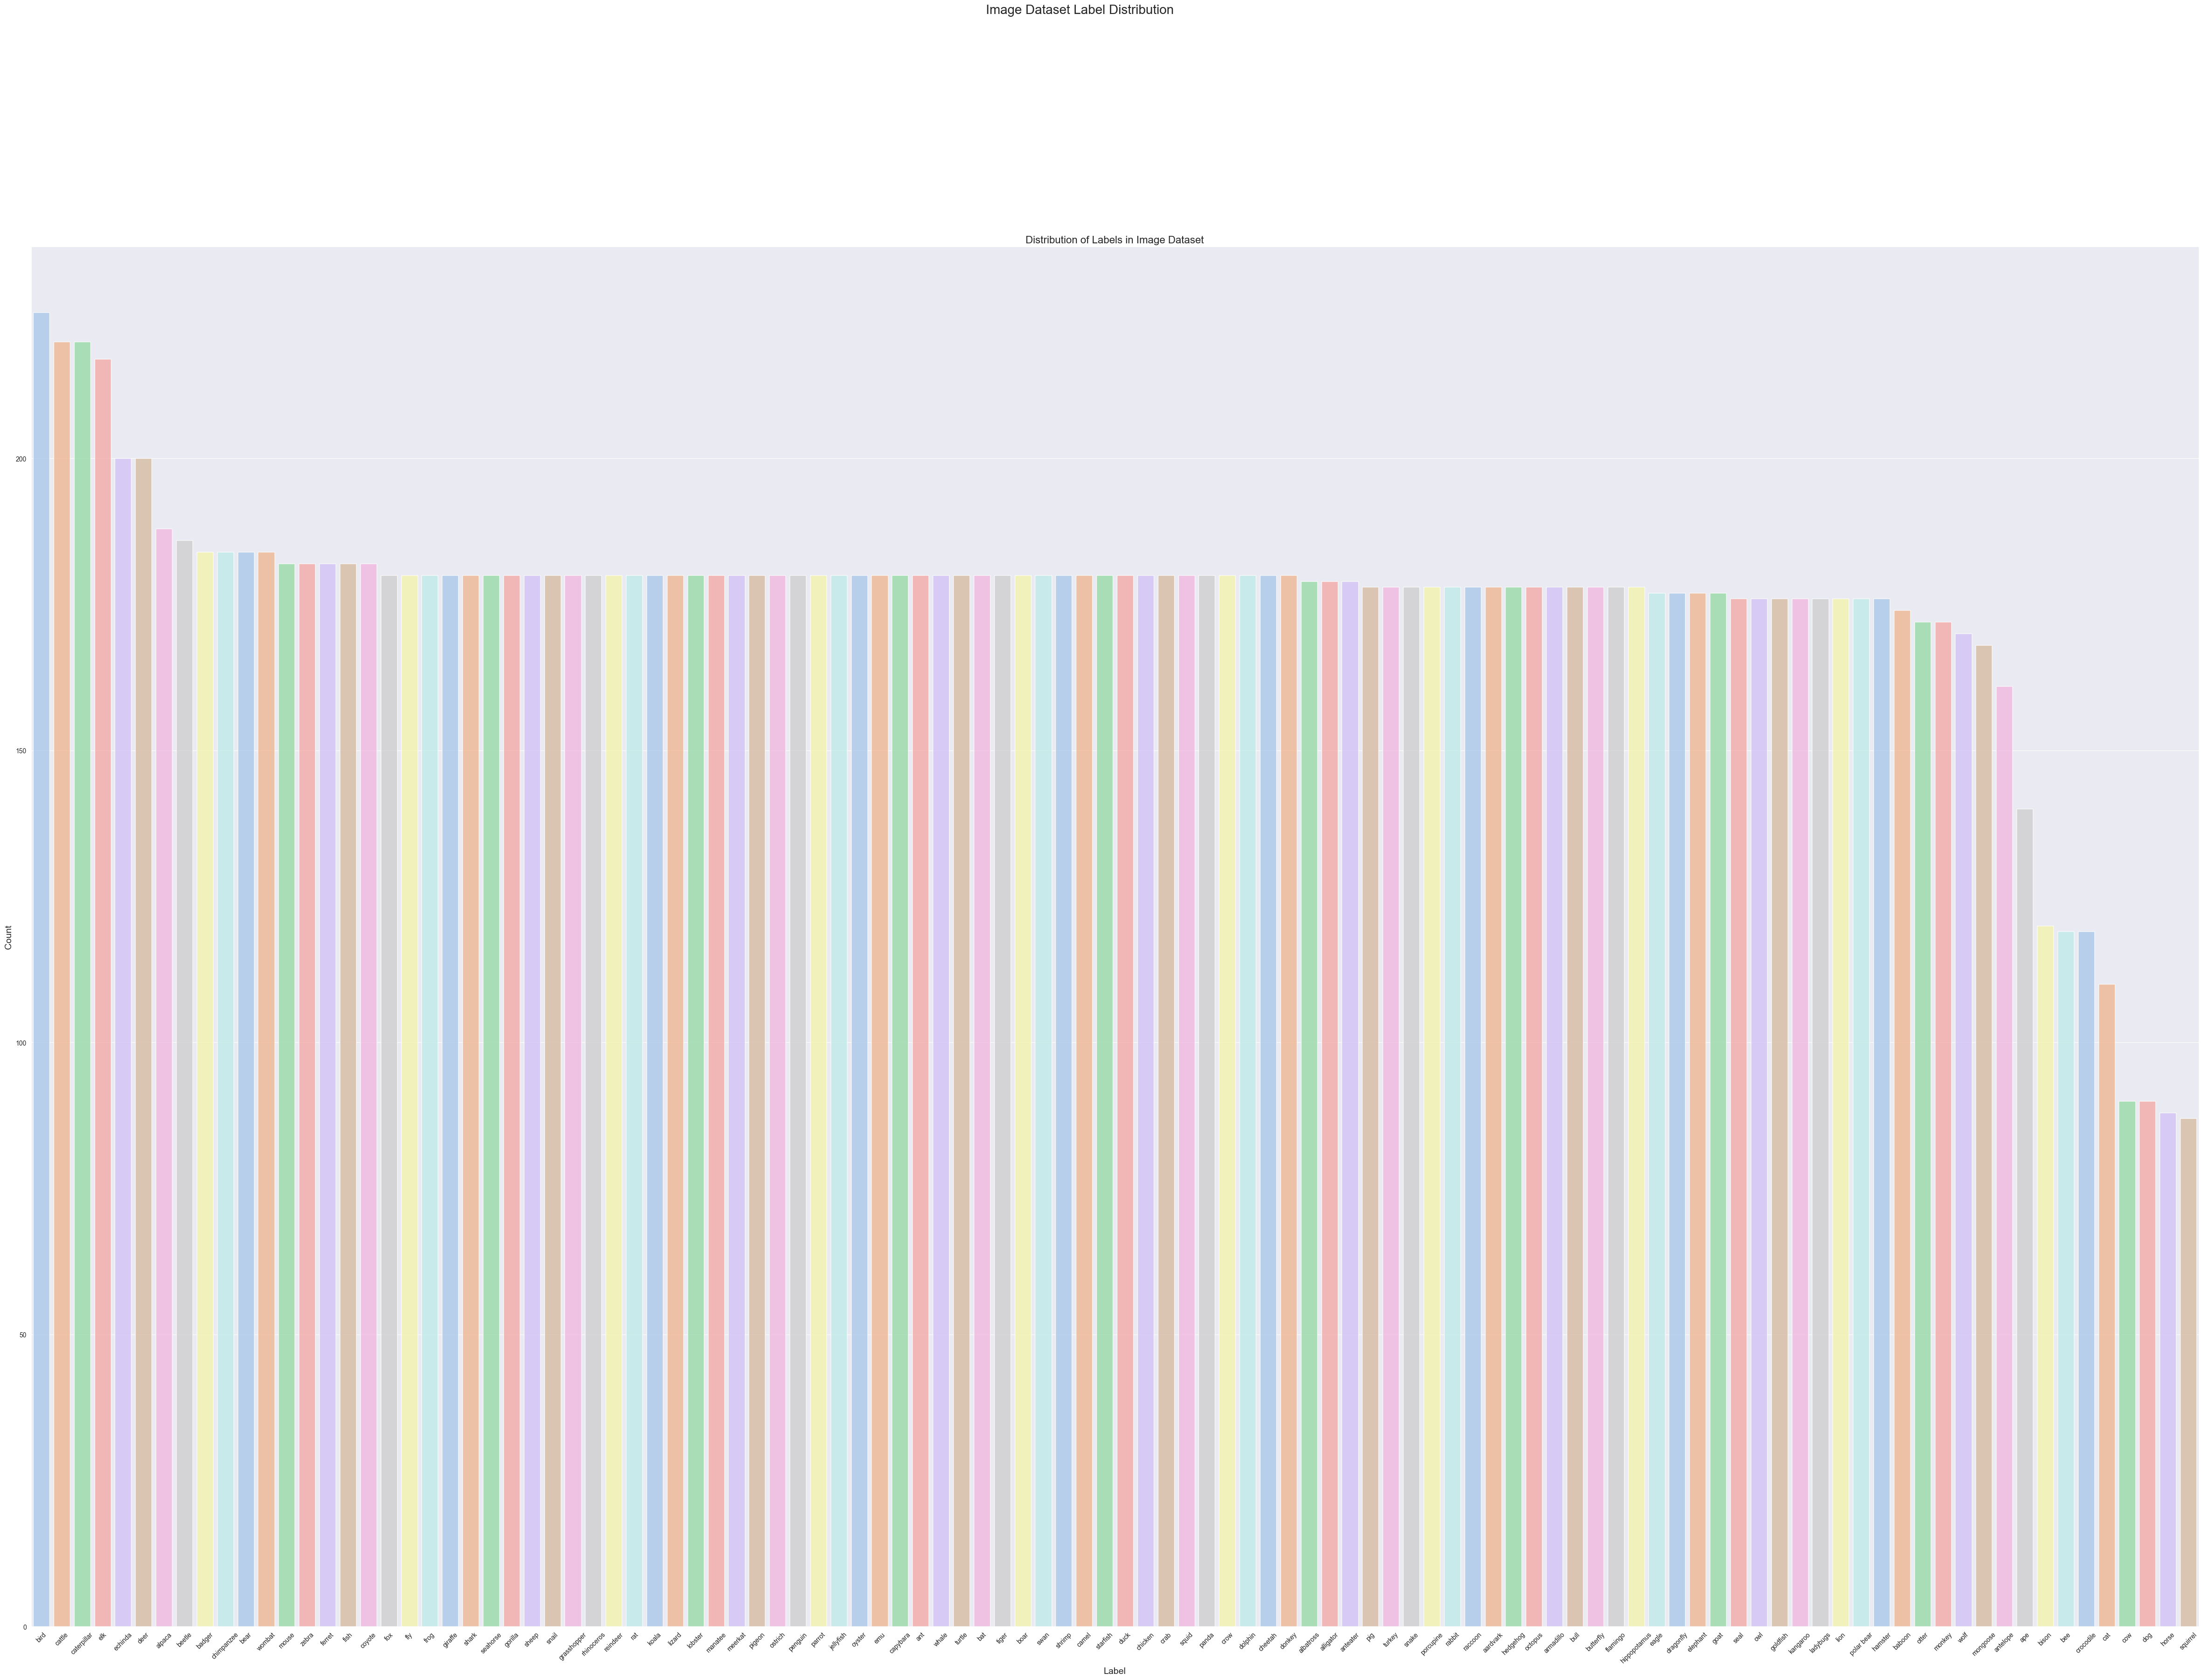

In [7]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()
print(label_counts)
# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(60, 40))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

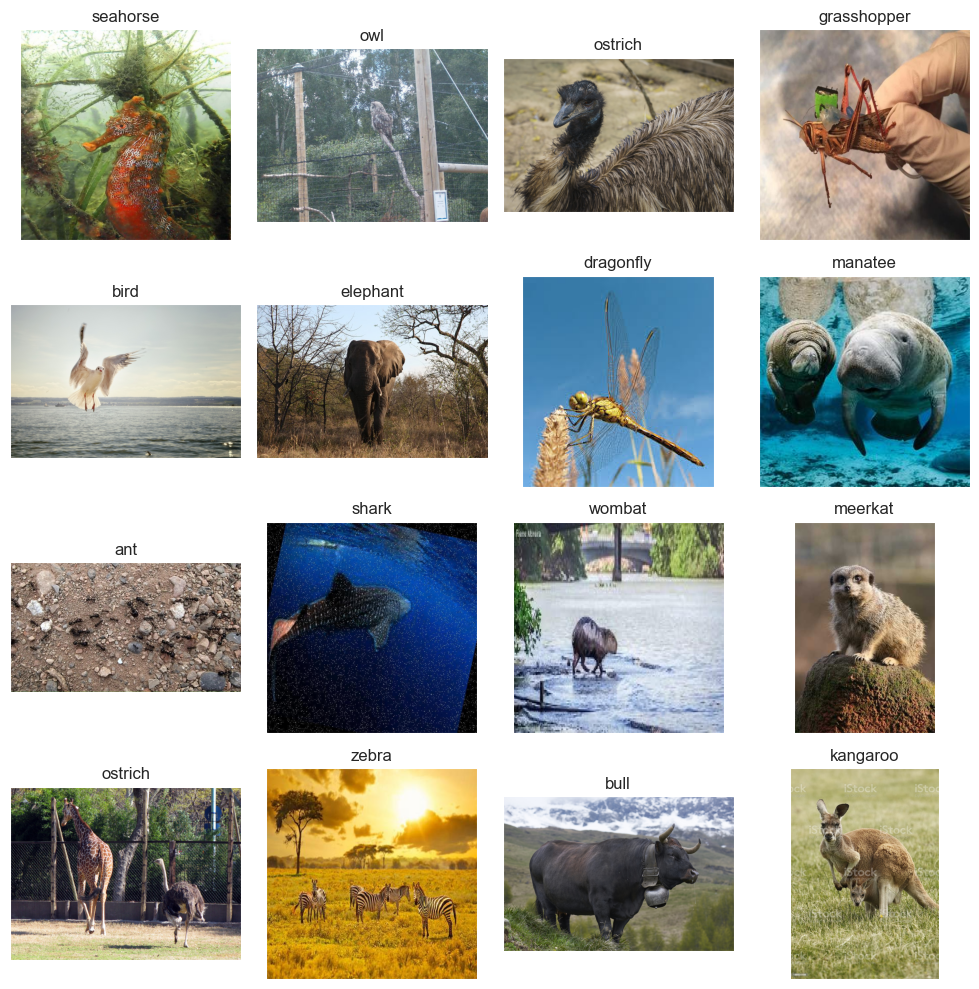

In [8]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

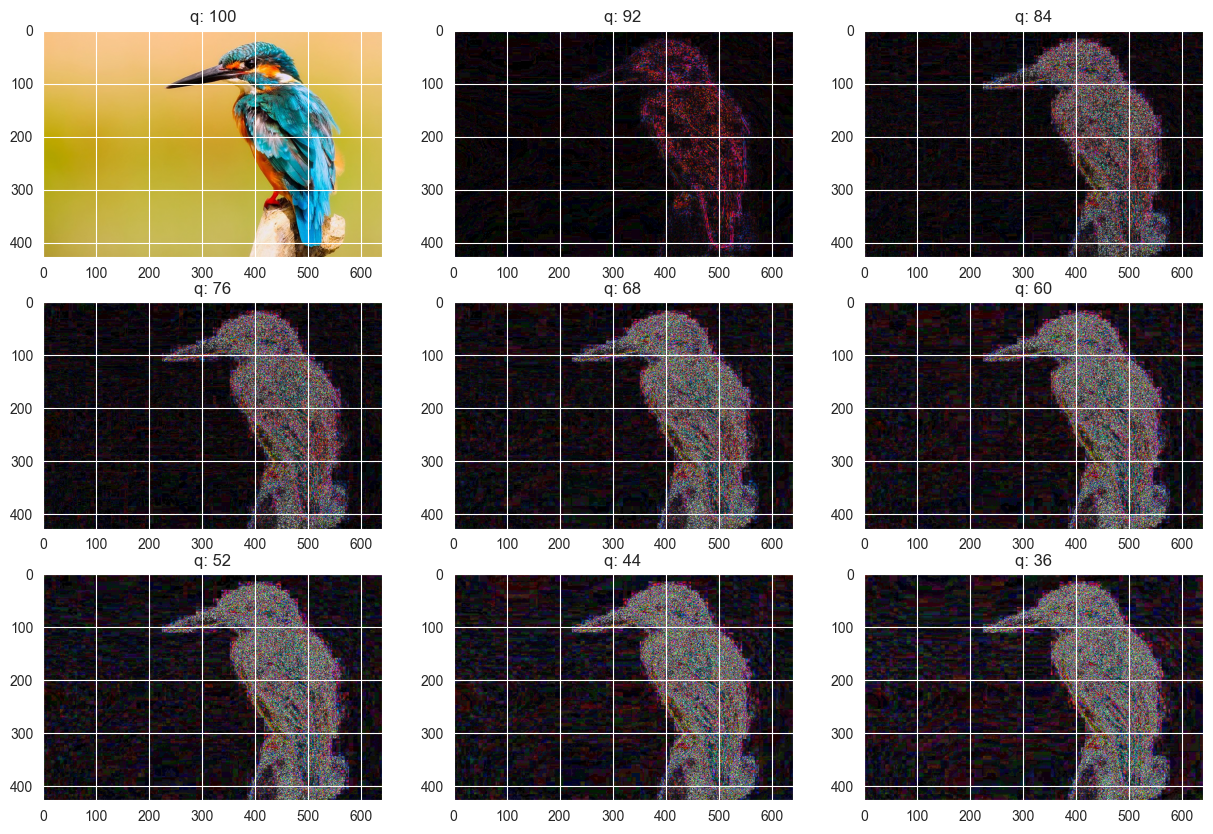

In [9]:
from PIL import Image, ImageChops, ImageEnhance

p = 'animals/bird/004_kingfisher-2046453_640.jpg'
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff



fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()


<h1>Applying SVM</h1>

In [11]:
from sklearn.preprocessing import LabelEncoder
# Encode the labels
le = LabelEncoder()
image_df['Label'] = le.fit_transform(image_df['Label'])

def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    image = image.flatten()  # Flatten the image
    return image

image_df['processed_images'] = image_df['Filepath'].apply(preprocess_image)

image_df.head()

Filepath  Label  \
0  animals\aardvark\images (10).jpg      0   
1  animals\aardvark\images (11).jpg      0   
2  animals\aardvark\images (12).jpg      0   
3  animals\aardvark\images (13).jpg      0   
4  animals\aardvark\images (14).jpg      0   

                                    processed_images  
0  [174, 176, 188, 185, 191, 207, 207, 211, 206, ...  
1  [41, 35, 39, 39, 31, 57, 70, 80, 53, 74, 66, 4...  
2  [133, 135, 181, 151, 99, 129, 77, 140, 76, 44,...  
3  [151, 201, 200, 201, 163, 159, 221, 226, 205, ...  
4  [58, 66, 59, 70, 93, 167, 70, 46, 131, 55, 93,...

In [12]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)

In [13]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(image_df['processed_images'].tolist(), image_df['Label'], test_size=0.2, random_state=42)

In [14]:
model.fit(X_train,y_train)

In [ ]:
from joblib import dump, load

# Save the trained model
dump(svm, 'svm_animal_classifier.joblib')

# Save the label encoder
dump(le, 'label_encoder.joblib')

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

# Load the model
svm = load('svm_animal_classifier.joblib')
le = load('label_encoder.joblib')

# Predict on the test set
y_pred = svm.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred, average='weighted')
svm_recall = recall_score(y_test, y_pred, average='weighted')
svm_report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f'Accuracy: {svm_accuracy}')
print(f'Precision: {svm_precision}')
print(f'Recall: {svm_recall}')
print(svm_report)

In [ ]:
def classify_image(image_path):
    # Preprocess the custom image
    image = preprocess_image(image_path)
    image = image.reshape(1, -1)  # Reshape to match training data format
    
    # Predict the class
    predicted_class_index = svm.predict(image)[0]
    predicted_class_label = le.inverse_transform([predicted_class_index])[0]
    
    return predicted_class_label

# Example usage
custom_image_path = 'test_images/bull.jpg'
predicted_class = classify_image(custom_image_path)
print(f'The predicted class with SVM classifier is: {predicted_class}')


<h1>Applying KNN</h1>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model=KNeighborsClassifier

In [ ]:
# Define the parameter grid
param_grid = {'n_neighbors': range(1, 20)}

In [ ]:
# Perform a grid search
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best parameter and the best estimator
best_k = grid_search.best_params_['n_neighbors']
best_knn = grid_search.best_estimator_
print(f'Optimal number of neighbors: {best_k}')

In [ ]:
# Train the KNN model with the best parameter
best_knn.fit(X_train, y_train)

In [ ]:
# Save the trained model
dump(best_knn, 'knn_animal_classifier.joblib')

In [ ]:
# Load the model
best_knn = load('knn_animal_classifier.joblib')
le = load('label_encoder.joblib')

# Predict on the test set
y_pred = best_knn.predict(X_test)

# Evaluate the model
knn_accuracy = accuracy_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred, average='weighted')
knn_recall = recall_score(y_test, y_pred, average='weighted')
knn_report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f'Accuracy: {knn_accuracy}')
print(f'Precision: {knn_precision}')
print(f'Recall: {knn_recall}')
print(knn_report)

In [ ]:
def classify_image(image_path):
    # Preprocess the custom image
    image = preprocess_image(image_path)
    image = image.reshape(1, -1)  # Reshape to match training data format
    
    # Predict the class
    predicted_class_index = best_knn.predict(image)[0]
    predicted_class_label = le.inverse_transform([predicted_class_index])[0]
    
    return predicted_class_label

# Example usage
custom_image_path = 'path_to_custom_image.jpg'
predicted_class = classify_image(custom_image_path)
print(f'The predicted class is: {predicted_class}')

<h1>Applying MLP</h1>

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# Train an MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

In [ ]:
# Save the trained model
dump(mlp, 'mlp_animal_classifier.joblib')

In [ ]:
# Load the model
mlp = load('mlp_animal_classifier.joblib')
le = load('label_encoder.joblib')

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the model
mlp_accuracy = accuracy_score(y_test, y_pred)
mlp_precision = precision_score(y_test, y_pred, average='weighted')
mlp_recall = recall_score(y_test, y_pred, average='weighted')
mlp_report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f'Accuracy: {mlp_accuracy}')
print(f'Precision: {mlp_precision}')
print(f'Recall: {mlp_recall}')
print(mlp_report)

In [ ]:
def classify_image(image_path):
    # Preprocess the custom image
    image = preprocess_image(image_path)
    image = image.reshape(1, -1)  # Reshape to match training data format
    
    # Predict the class
    predicted_class_index = mlp.predict(image)[0]
    predicted_class_label = le.inverse_transform([predicted_class_index])[0]
    
    return predicted_class_label

# Example usage
custom_image_path = 'path_to_custom_image.jpg'
predicted_class = classify_image(custom_image_path)
print(f'The predicted class from MLP Classifier is: {predicted_class}')

<h1>Applying Random Forest</h1>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Different values to try
}

In [ ]:
# Perform grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

In [ ]:
# Get the best parameter and the best estimator
best_n_estimators = grid_search.best_params_['n_estimators']
best_rf = grid_search.best_estimator_

print(f'Optimal number of estimators: {best_n_estimators}')


In [ ]:
best_rf.fit(X_train,y_train)

In [ ]:
# Save the best model
dump(best_rf, 'best_rf_animal_classifier.joblib')

In [ ]:
# Load the model
best_rf = load('rf_animal_classifier.joblib')
le = load('label_encoder.joblib')

# Predict on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average='weighted')
rf_recall = recall_score(y_test, y_pred, average='weighted')
rf_report = classification_report(y_test, y_pred, target_names=le.classes_)

print(f'Accuracy: {rf_accuracy}')
print(f'Precision: {rf_precision}')
print(f'Recall: {rf_recall}')
print(rf_report)

In [ ]:
def classify_image(image_path):
    # Preprocess the custom image
    image = preprocess_image(image_path)
    image = image.reshape(1, -1)  # Reshape to match training data format
    
    # Predict the class
    predicted_class_index = best_rf.predict(image)[0]
    predicted_class_label = le.inverse_transform([predicted_class_index])[0]
    
    return predicted_class_label

# Example usage
custom_image_path = 'path_to_custom_image.jpg'
predicted_class = classify_image(custom_image_path)
print(f'The predicted class is: {predicted_class}')
